In [17]:
import os
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nptdms import TdmsFile as TF
import datetime
from datetime import timedelta as td
%matplotlib inline



class MHDPlots(object):
    def __init__(self, ):
        self.samples = []
        self.pathnames = []
        self.filenames = []
        self.imports = {}
        self.data = {}
    
    def set_path(self, path):
        samples = self.samples
        pathnames = self.pathnames
        for file in os.listdir(path):
            samples = np.append(samples, str(file))
        for sample in samples:
            this = glob(path+"\\"+sample+"\\*_together.tdms")
            pathnames = np.append(pathnames, this)
        self.pathnames = pathnames    
        self.samples = samples
        return
    
    def importdata(self, string):
        #Will import all data in the defined file path with substring input
        pathnames = self.pathnames
        imports = self.imports
        for pathname in pathnames:
            if string in pathname:
                imports[pathname] = TF(pathname)
        self.imports = imports
        self.get_times()
        return
    
    def get_times(self, ):
        #Fills the data dictionary with initial arrays of time, to stack with other data in future
        data = self.data
        imports = self.imports
        for string in imports:
            file = imports[string]
            data[string] = file.object("Global", "Time").data
        self.data = data
        return
    
    def get_data(self, channelname ):
        #finds data corresponding to a channel name, and stacks with respective time arrays
        data = self.data
        imports = self.imports
        for string in self.imports:
            file = imports[string]
            groups = file.groups()
            for group in groups:
                channels = file.group_channels(group)
                for channel in channels:
                    if channelname == channel.channel:
                        subdata = channel.data
            length = len(np.transpose(data[string]))
            if len(subdata) != length:
                subdata = self.resize(subdata, length)
            data[string] = np.vstack((data[string], subdata))
        self.data = data
        return subdata, len(data[string])
    
    def get_blackbody(self,):
        
        data, pos = self.get_data( )
        return
    
    def resize(self, arr, length):
        if len(arr)>length:
            arr = arr[1:]
        elif len(arr)<length:
            arr = np.append(arr, 0)
        else:
            print("error")
        return arr
        
    

In [18]:
a = MHDPlots()
a.set_path("D:\\Data\\MolyRod")

In [19]:
a.importdata("MolyA\\13mm_together.tdms")

In [20]:
data = a.get_data("T_Sample (Arith. Mean)")

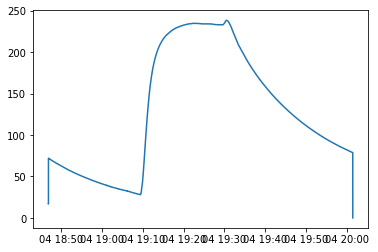

In [21]:
for string in data:
    plt.plot(data[string][0],data[string][1])

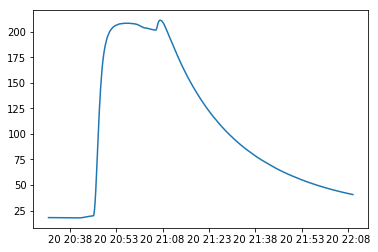

In [14]:
plt.plot(stuff[0], stuff[1])

In [169]:
len(np.transpose(array))

3

In [170]:
array2 = [4,5,6,7]
if len(np.transpose(array))!=len(array2):
    array, array2 = resize(array, array2)
array = np.vstack((array,array2))


In [171]:
array

array([[1, 2, 3],
       [4, 5, 6],
       [5, 6, 7]])